In [44]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from sklearn.preprocessing import StandardScaler

print('Libraries imported.')

Libraries imported.


## Reading Berlin Population data

In [265]:
url = r'https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins'
tables = pd.read_html(url) # Returns list of all tables on page
population = tables[1] # Select table of interest
population.head()

,Nr.,Ortsteil,Bezirk,Fläche(km²),Einwohner[2](31. Dezember 2019),Einwohnerpro km²
0,101,Mitte,Mitte,1070,102.465,9576.000
1,102,Moabit,Mitte,772,80.495,10.427
2,103,Hansaviertel,Mitte,53,5.926,11.181
3,104,Tiergarten,Mitte,517,14.881,2878.000
4,105,Wedding,Mitte,923,86.806,9405.000


#### population analisys

In [274]:
population.groupby(['Bezirk']).sum().sort_values(['Einwohnerpro km²'], ascending=False)

,Nr.,Fläche(km²),Einwohner[2](31. Dezember 2019),Einwohnerpro km²
Bezirk,,,,
Treptow-Köpenick,13620,16570,273.689,46657.000
Lichtenberg,11065,5202,928.566,44584.104
Pankow,3991,10326,409.335,38831.474
Reinickendorf,13266,8940,266.408,31780.618
Spandau,4545,9190,245.197,30638.000
Steglitz-Zehlendorf,4228,10247,310.071,25173.164
Mitte,621,3948,385.748,21896.134
Tempelhof-Schöneberg,4221,5308,350.984,19469.740
Charlottenburg-Wilmersdorf,2828,6462,343.592,17418.964


## Reading Berlin Crimes data

In [385]:
import pandas as pd
crimes = pd.read_csv("Berlin_crimes.csv")

# take the crime on year 2019
crimes2019 = crimes.loc[crimes['Year'] == 2019]
crimes2019.head()

,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local
1050,2019,Mitte,10111,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980
1051,2019,Mitte,10112,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057
1052,2019,Mitte,10113,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813
1053,2019,Mitte,10114,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902
1054,2019,Mitte,10221,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409


#### Crimes analisys

In [391]:
crimes2019[['District','Code','Location','Robbery','Drugs']].head()

,District,Code,Location,Robbery,Drugs
1050,Mitte,10111,Tiergarten Süd,60,231
1051,Mitte,10112,Regierungsviertel,42,170
1052,Mitte,10113,Alexanderplatz,173,1133
1053,Mitte,10114,Brunnenstraße Süd,40,86
1054,Mitte,10221,Moabit West,66,618


In [304]:
crimes2019.groupby(['District'])['Robbery','Drugs'].sum().sort_values(['Drugs'], ascending=False).head()

,Robbery,Drugs
District,,
Friedrichshain-Kreuzberg,820,5232
Mitte,707,4233
Neukölln,480,2126
Tempelhof-Schöneberg,352,1209
Charlottenburg-Wilmersdorf,420,1174


In [294]:
crimes2019.groupby(['District'])['Robbery','Drugs'].sum().sort_values(['Robbery'], ascending=False).head()

,Robbery,Drugs
District,,
Friedrichshain-Kreuzberg,820,5232
Mitte,707,4233
Neukölln,480,2126
Charlottenburg-Wilmersdorf,420,1174
Tempelhof-Schöneberg,352,1209


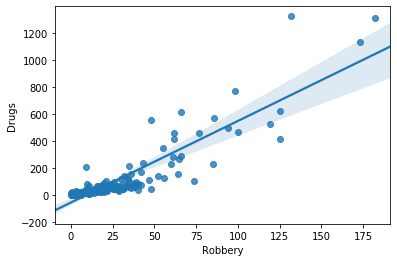

In [295]:
sns.regplot(x='Robbery',y='Drugs',data=crimes2019)

## Procesing the Data

### add density to crime DF

In [4]:
crimes2019_density = crimes2019

for i, c in crimes2019.iterrows():
    normalizedCode = str(c['Code'])[:-2]
    density = np.NaN
    if population.loc[population['Nr.'] == int(normalizedCode)].shape[0] != 0:
        density = population.loc[population['Nr.'] == int(normalizedCode)]['Einwohnerpro km²'].item()   
    crimes2019_density.at[i,'Density'] = density
    crimes2019_density.at[i,'Code'] = normalizedCode
    
print(crimes2019_density.shape)
crimes2019_density.head()

/Users/javier.inocente/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/javier.inocente/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(150, 21)


,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,Density
1050,2019,Mitte,101,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980,9576.000
1051,2019,Mitte,101,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057,9576.000
1052,2019,Mitte,101,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813,9576.000
1053,2019,Mitte,101,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902,9576.000
1054,2019,Mitte,102,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409,10.427


### Sanitizing NaNs

In [5]:
crimes2019_density[crimes2019_density['Density'].isnull()]

,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,Density
1060,2019,Mitte,199,"Bezirk (Mi), nicht zuzuordnen",5,4,19,7,5,94,0,6,10,0,0,0,15,7,17,34,NaN
1063,2019,Friedrichshain-Kreuzberg,203,nördliche Luisenstadt,94,67,524,215,99,2509,27,238,300,48,26,8,407,84,493,1103,NaN
1064,2019,Friedrichshain-Kreuzberg,203,südliche Luisenstadt,182,150,530,251,125,2343,37,219,440,52,44,15,519,104,1310,1316,NaN
1065,2019,Friedrichshain-Kreuzberg,204,Karl-Marx-Allee-Nord,38,26,225,58,61,1260,50,132,222,45,8,5,298,59,58,634,NaN
1066,2019,Friedrichshain-Kreuzberg,204,Karl-Marx-Allee-Süd,98,74,787,281,160,3618,36,215,334,33,20,9,480,120,770,1573,NaN
1067,2019,Friedrichshain-Kreuzberg,205,Frankfurter Allee Nord,30,16,376,109,96,1839,33,84,353,49,48,9,604,118,121,1212,NaN
1068,2019,Friedrichshain-Kreuzberg,205,Frankfurter Allee Süd FK,132,92,972,353,168,4273,48,259,775,68,39,15,1062,335,1322,2606,NaN
1069,2019,Friedrichshain-Kreuzberg,299,"Bezirk (Fh-Kb), nicht zuzuordnen",2,2,4,2,2,38,0,1,5,0,1,1,3,1,9,10,NaN
1086,2019,Pankow,399,"Bezirk (Pk), nicht zuzuordnen",1,1,11,3,1,53,1,8,10,0,1,0,8,2,13,18,NaN
1104,2019,Charlottenburg-Wilmersdorf,499,"Bezirk (Ch-Wi), nicht zuzuordnen",1,1,3,2,7,40,1,8,9,0,2,2,4,0,1,11,NaN


From the list above, it will deleted the elemens in the coloum "Location" that containt "nicht zuzuordnen" -> not assignable

In [6]:
crimes2019_density = crimes2019_density[~crimes2019_density.Location.str.contains("nicht zuzuordne")]
crimes2019_density.shape

(138, 21)

#### Now lets see how many NaN remains in the data

In [7]:
crimes2019_density[crimes2019_density['Density'].isnull()]

,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,Density
1063,2019,Friedrichshain-Kreuzberg,203,nördliche Luisenstadt,94,67,524,215,99,2509,27,238,300,48,26,8,407,84,493,1103,NaN
1064,2019,Friedrichshain-Kreuzberg,203,südliche Luisenstadt,182,150,530,251,125,2343,37,219,440,52,44,15,519,104,1310,1316,NaN
1065,2019,Friedrichshain-Kreuzberg,204,Karl-Marx-Allee-Nord,38,26,225,58,61,1260,50,132,222,45,8,5,298,59,58,634,NaN
1066,2019,Friedrichshain-Kreuzberg,204,Karl-Marx-Allee-Süd,98,74,787,281,160,3618,36,215,334,33,20,9,480,120,770,1573,NaN
1067,2019,Friedrichshain-Kreuzberg,205,Frankfurter Allee Nord,30,16,376,109,96,1839,33,84,353,49,48,9,604,118,121,1212,NaN
1068,2019,Friedrichshain-Kreuzberg,205,Frankfurter Allee Süd FK,132,92,972,353,168,4273,48,259,775,68,39,15,1062,335,1322,2606,NaN
1130,2019,Tempelhof-Schöneberg,707,Lichtenrade,33,22,329,54,129,1008,80,225,126,95,36,12,398,71,69,675,NaN
1185,2019,Lichtenberg,1105,Rummelsburger Bucht,4,3,58,14,20,332,11,55,99,12,9,6,80,28,11,147,NaN
1186,2019,Lichtenberg,1105,Karlshorst,6,6,117,26,49,720,38,112,171,73,8,4,131,24,13,288,NaN
1190,2019,Reinickendorf,1221,West 1 - Tegel-Süd/Flughafensee,9,4,256,69,109,1233,21,217,43,37,9,3,142,6,210,528,NaN


It is possible to see that the "Code" does not match the list for Codes in the population table. However the name of the Distric can be matched with the coloum "Bezirk" I would prefere to keep this values, rather than delete them. I will make a mean of the "Bezirk" and assing the mean to each of the NaN inthe table crimes2019_density

In [8]:
for i, c in crimes2019_density[crimes2019_density['Density'].isnull()].iterrows():
    density= population.loc[population['Bezirk'] == c['District']].groupby(['Bezirk'])['Einwohnerpro km²'].mean().item()
    crimes2019_density.at[i,'Density'] = density

In [9]:
print('NaN elements in consolodidated table: ',crimes2019_density[crimes2019_density['Density'].isnull()].shape[0])
print('total number of elements: ',crimes2019_density.shape[0])

NaN elements in consolodidated table:  0
total number of elements:  138


In [10]:
crimes2019_density.head()

,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,Density
1050,2019,Mitte,101,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980,9576.000
1051,2019,Mitte,101,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057,9576.000
1052,2019,Mitte,101,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813,9576.000
1053,2019,Mitte,101,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902,9576.000
1054,2019,Mitte,102,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409,10.427


## Adding venues to the table

In [11]:
berlin_df = crimes2019_density

### Will reset the indexs and remove the old ones. Then the coloum year is also deleted

In [245]:
berlin_df = berlin_df.reset_index().drop(['index'], axis=1)
berlin_df.head()

,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,Density,Latitud,Longitud
0,Mitte,101,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980,9576.000,52.5038,13.3634
1,Mitte,101,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057,9576.000,52.5195,13.3765
2,Mitte,101,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813,9576.000,52.522,13.4136
3,Mitte,101,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902,9576.000,52.5177,13.4024
4,Mitte,102,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409,10.427,52.5301,13.3425


In [13]:
berlin_df = berlin_df.drop(['Year'], axis=1)

In [14]:
berlin_df.head()

,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,Density
0,Mitte,101,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980,9576.000
1,Mitte,101,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057,9576.000
2,Mitte,101,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813,9576.000
3,Mitte,101,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902,9576.000
4,Mitte,102,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409,10.427


In [15]:
berlin_df['Latitud']='nan'
berlin_df['Longitud']='nan'

In [16]:
geolocator = Nominatim(user_agent="berlin_explorer")
for n in range(len(berlin_df)):   
    district = berlin_df['District'][n]
    zipcode= berlin_df['Code'][n]
    loc = berlin_df['Location'][n]
    address = '{} {}, Berlin'.format(loc, zipcode)
    location = geolocator.geocode(address)
    if location != None:
        berlin_df['Latitud'][n]=location.latitude
        berlin_df['Longitud'][n]=location.longitude
        continue
    address = '{} {}, Berlin'.format(district, zipcode)   
    location = geolocator.geocode(address)
    if location != None:
        berlin_df['Latitud'][n]=location.latitude
        berlin_df['Longitud'][n]=location.longitude

/Users/javier.inocente/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/javier.inocente/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/javier.inocente/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykerne

In [17]:
berlin_df.head()

,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,Density,Latitud,Longitud
0,Mitte,101,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980,9576.000,52.5038,13.3634
1,Mitte,101,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057,9576.000,52.5195,13.3765
2,Mitte,101,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813,9576.000,52.522,13.4136
3,Mitte,101,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902,9576.000,52.5177,13.4024
4,Mitte,102,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409,10.427,52.5301,13.3425


### Creating the map

In [305]:
# Map of Berlin
berlin_location = 'Berlin, Germany'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(berlin_location)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin {}, {}.'.format(latitude, longitude))

map_berlin = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighbourhood, postalcode in zip(berlin_df['Latitud'], berlin_df['Longitud'], berlin_df['District'], berlin_df['Location'], berlin_df['Code']):
    label = '{} - {} - {}'.format(neighbourhood, borough,postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#a3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

The geograpical coordinate of Berlin 52.5170365, 13.3888599.


## Restoring the credential... the credential file is not commited for securitx reasons

In [20]:
%store -r CLIENT_ID
%store -r CLIENT_SECRET
VERSION = '20190425'
LIMIT = 100 # A default Foursquare API limit value
print('credential loaded')

credential loaded


In [122]:
def getNearbyVenues(names, codes, latitudes, longitudes, robberies, drugs, densities, radius=500):
    
    venues_list=[]
    for name, code,  lat, lng, robbery, drugs, density in zip(names, codes, latitudes, longitudes, robberies, drugs, densities):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            code,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            robbery,
            drugs,
            density) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'ZipCode',
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Robbery',
                  'Venue Drugs',
                  'Venue Density']
    
    return(nearby_venues)

In [123]:
berlin_venues = getNearbyVenues(names=berlin_df['District'],codes=berlin_df['Code'],latitudes=berlin_df['Latitud'],longitudes=berlin_df['Longitud'],robberies=berlin_df['Robbery'],drugs=berlin_df['Drugs'],densities=berlin_df['Density'])

Mitte
Mitte
Mitte
Mitte
Mitte
Mitte
Mitte
Mitte
Mitte
Mitte
Friedrichshain-Kreuzberg
Friedrichshain-Kreuzberg
Friedrichshain-Kreuzberg
Friedrichshain-Kreuzberg
Friedrichshain-Kreuzberg
Friedrichshain-Kreuzberg
Friedrichshain-Kreuzberg
Friedrichshain-Kreuzberg
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Pankow
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Charlottenburg-Wilmersdorf
Spandau
Spandau
Spandau
Spandau
Spandau
Spandau
Spandau
Spandau
Spandau
Steglitz-Zehlendorf
Steglitz-Zehlendorf
Steglitz-Zehlendorf
Steglitz-Zehlendorf
Steglitz-Zehlendo

In [291]:
berlin_venues.groupby('Neighbourhood').count().sort_values(['Venue'], ascending=False)

,ZipCode,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Robbery,Venue Drugs,Venue Density
Neighbourhood,,,,,,,,,,
Friedrichshain-Kreuzberg,716,716,716,716,716,716,716,716,716,716
Charlottenburg-Wilmersdorf,444,444,444,444,444,444,444,444,444,444
Mitte,424,424,424,424,424,424,424,424,424,424
Neukölln,342,342,342,342,342,342,342,342,342,342
Pankow,300,300,300,300,300,300,300,300,300,300
Steglitz-Zehlendorf,196,196,196,196,196,196,196,196,196,196
Treptow-Köpenick,184,184,184,184,184,184,184,184,184,184
Spandau,129,129,129,129,129,129,129,129,129,129
Lichtenberg,111,111,111,111,111,111,111,111,111,111


In [129]:
# one hot encoding
berlin_venues_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
berlin_venues_onehot['Neighbourhood'] = berlin_venues['Neighbourhood'] 
berlin_venues_onehot['ZipCode'] = berlin_venues['ZipCode'] 
berlin_venues_onehot['Venue Robbery'] = berlin_venues['Venue Robbery'] 
berlin_venues_onehot['Venue Drugs'] = berlin_venues['Venue Drugs'] 
berlin_venues_onehot['Venue Density'] = berlin_venues['Venue Density'] 


# move Neighbourhood column to the first column
fixed_columns = [berlin_venues_onehot.columns[-5]] + [berlin_venues_onehot.columns[-4]]   + [berlin_venues_onehot.columns[-3]] + [berlin_venues_onehot.columns[-2]]+ [berlin_venues_onehot.columns[-1]]   + list(berlin_venues_onehot.columns[:-4])
berlin_venues_onehot = berlin_venues_onehot[fixed_columns]

berlin_venues_onehot.shape

(3041, 294)

In [130]:
berlin_venues_onehot.head()

,Neighbourhood,ZipCode,Venue Robbery,Venue Drugs,Venue Density,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Industrial Estate,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kofte Place,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Newsstand,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pide Place,Pie Shop,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Summer Camp,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Trattoria/Osteria,Tree,Tunnel,Turkish Restaurant,Vegetaria

In [246]:
berlin_grouped = berlin_venues_onehot.groupby('ZipCode').mean().reset_index()
berlin_grouped.head()

,ZipCode,Venue Robbery,Venue Drugs,Venue Density,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Industrial Estate,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kofte Place,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Newsstand,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pide Place,Pie Shop,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Summer Camp,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Trattoria/Osteria,Tree,Tunnel,Turkish Restaurant,Vegetarian / Vegan Rest

## Clusterization

#### Lets start finding the best K for clusterization

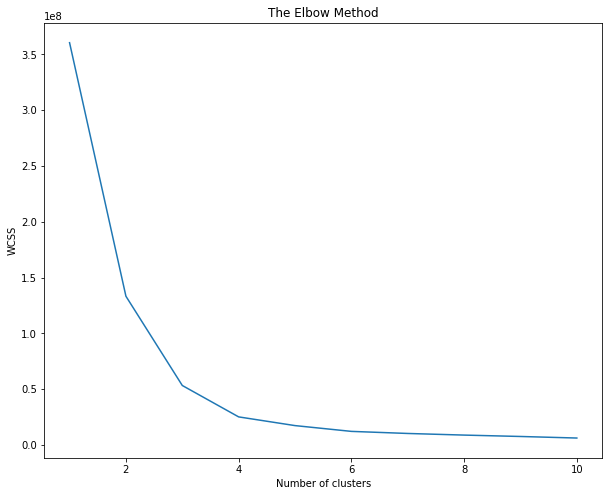

In [133]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 11):
    kmeans_best_fit = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_best_fit.fit(berlin_grouped )
    wcss.append(kmeans_best_fit.inertia_) #criterion based on which K-means clustering works
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### Start the clusterization with KMEANS

In [134]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(berlin_grouped)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_

In [135]:
#del berlin_crimes_df['Cluster Labels']
berlin_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [149]:
berlin_grouped.shape

(59, 293)

In [148]:
berlin_grouped.loc[berlin_grouped['Cluster Labels'] == 1, berlin_grouped.columns[[1] + list(range(2, berlin_grouped.shape[1]-1))]]


,ZipCode,Venue Robbery,Venue Drugs,Venue Density,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Capitol Building,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Industrial Estate,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kofte Place,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Newsstand,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pide Place,Pie Shop,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Summer Camp,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Trattoria/Osteria,Tree,Tunnel,Turkish Restaurant,Vegetarian / Vegan Rest

#### Sortin the 10th most commons venues

In [140]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [160]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        
        
        
# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['ZipCode'] = berlin_grouped['ZipCode']

for ind in np.arange(berlin_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, 4:], num_top_venues)

neighbourhoods_venues_sorted.head()

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,101,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
1,102,German Restaurant,Café,Bar,Supermarket,Hostel,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Cocktail Bar,Burger Joint,Italian Restaurant
2,103,German Restaurant,Hotel,Turkish Restaurant,History Museum,Museum,Café,Bar,Art Gallery,Fountain,Bakery
3,104,Bakery,Supermarket,Restaurant,Bus Stop,Pool Hall,Soccer Stadium,Shopping Mall,Seafood Restaurant,Rock Club,River
4,201,Bar,Café,Pizza Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Bakery,Falafel Restaurant,Italian Restaurant,Pub,Vietnamese Restaurant


In [161]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [166]:
berlin_merged = berlin_df

berlin_merged = berlin_merged.join(neighbourhoods_venues_sorted.set_index('ZipCode'), on='Code')

In [190]:
berlin_merged = berlin_merged.dropna(subset=['Cluster Labels'])

In [195]:
berlin_merged = berlin_merged.astype({'Cluster Labels': int} ) 

#### Creating a map with the labeled venues

In [423]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['Latitud'], berlin_merged['Longitud'], berlin_merged['District'], berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [199]:
berlin_merged.head()

,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,Density,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mitte,101,Tiergarten Süd,60,35,365,92,128,2271,15,198,296,55,13,6,347,77,231,980,9576.000,52.5038,13.3634,3,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
1,Mitte,101,Regierungsviertel,42,20,554,136,152,3692,13,172,352,22,19,4,497,162,170,1057,9576.000,52.5195,13.3765,3,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
2,Mitte,101,Alexanderplatz,173,102,1966,500,420,11233,63,587,940,137,43,12,1307,381,1133,3813,9576.000,52.522,13.4136,3,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
3,Mitte,101,Brunnenstraße Süd,40,29,268,64,79,1859,39,182,361,64,18,7,424,172,86,902,9576.000,52.5177,13.4024,3,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
4,Mitte,102,Moabit West,66,29,685,210,202,2107,47,322,326,93,28,15,641,91,618,1409,10.427,52.5301,13.3425,1,German Restaurant,Café,Bar,Supermarket,Hostel,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Cocktail Bar,Burger Joint,Italian Restaurant


#### rearanging the colums to a better vesialization

In [237]:
berlin_final_df = berlin_merged

cluster_labels_final_column = berlin_final_df.columns[-11]
location_final_column = berlin_final_df.columns[2]
district_final_column = berlin_final_df.columns[0]
longitud_final_column = berlin_final_df.columns[21]
latitud_final_column = berlin_final_df.columns[20]
robbery_final_column = berlin_final_df.columns[3]
drugs_final_column = berlin_final_df.columns[17]
density_final_column = berlin_final_df.columns[19]
venues_final_column = list(berlin_final_df.columns[-10:])


# move Neighbourhood column to the first column
fixed_columns = [cluster_labels_final_column] + [location_final_column] + [district_final_column] + [longitud_final_column] + [latitud_final_column]  + [robbery_final_column] + [drugs_final_column] + [density_final_column] +  venues_final_column
berlin_final_df = berlin_final_df[fixed_columns]

berlin_final_df.head()

,Cluster Labels,Location,District,Longitud,Latitud,Robbery,Drugs,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Tiergarten Süd,Mitte,13.3634,52.5038,60,231,9576.000,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
1,3,Regierungsviertel,Mitte,13.3765,52.5195,42,170,9576.000,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
2,3,Alexanderplatz,Mitte,13.4136,52.522,173,1133,9576.000,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
3,3,Brunnenstraße Süd,Mitte,13.4024,52.5177,40,86,9576.000,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
4,1,Moabit West,Mitte,13.3425,52.5301,66,618,10.427,German Restaurant,Café,Bar,Supermarket,Hostel,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Cocktail Bar,Burger Joint,Italian Restaurant


In [241]:
berlin_final_df = berlin_final_df.astype({'Density': int} ) 

## Exploring the generated clusters

#### Analizyng cluster labeled 0

In [316]:
cluster_label_0 = berlin_final_df.loc[berlin_final_df['Cluster Labels'] == 0, berlin_final_df.columns[[1] + list(range(2, berlin_final_df.shape[1]))]]
cluster_label_0.head()

,Location,District,Longitud,Latitud,Robbery,Drugs,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Blankenfelde/Niederschönhausen,Pankow,13.4364,52.5976,7,22,6814,Turkish Restaurant,Garden Center,Supermarket,Tram Station,Drugstore,Chinese Restaurant,Asian Restaurant,Filipino Restaurant,Fabric Shop,Falafel Restaurant
20,Buchholz,Pankow,13.4281,52.6105,3,9,6814,Turkish Restaurant,Garden Center,Supermarket,Tram Station,Drugstore,Chinese Restaurant,Asian Restaurant,Filipino Restaurant,Fabric Shop,Falafel Restaurant
37,Schloß Charlottenburg,Charlottenburg-Wilmersdorf,13.2927,52.5206,26,54,6185,Hotel,Café,Italian Restaurant,German Restaurant,Coffee Shop,Vietnamese Restaurant,Bakery,Drugstore,Burger Joint,Supermarket
38,Mierendorffplatz,Charlottenburg-Wilmersdorf,13.3044,52.5257,26,48,6185,Hotel,Café,Italian Restaurant,German Restaurant,Coffee Shop,Vietnamese Restaurant,Bakery,Drugstore,Burger Joint,Supermarket
39,Otto-Suhr-Allee,Charlottenburg-Wilmersdorf,13.3215,52.5132,31,84,6185,Hotel,Café,Italian Restaurant,German Restaurant,Coffee Shop,Vietnamese Restaurant,Bakery,Drugstore,Burger Joint,Supermarket


In [322]:
cluster_label_0.groupby('District').sum().sort_values(['Robbery'], ascending=False)

,Robbery,Drugs,Density
District,,,
Charlottenburg-Wilmersdorf,258,650,58091
Lichtenberg,190,371,44601
Marzahn-Hellersdorf,117,253,17079
Tempelhof-Schöneberg,109,395,15906
Spandau,97,359,14781
Steglitz-Zehlendorf,97,202,21940
Treptow-Köpenick,63,210,22300
Neukölln,48,47,6410
Pankow,10,31,13628


#### Analizyng cluster labeled 1

In [319]:
cluster_label_1 = berlin_final_df.loc[berlin_final_df['Cluster Labels'] == 1, berlin_final_df.columns[[1] + list(range(2, berlin_final_df.shape[1]))]]
cluster_label_1.head()

,Location,District,Longitud,Latitud,Robbery,Drugs,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Moabit West,Mitte,13.3425,52.5301,66,618,10,German Restaurant,Café,Bar,Supermarket,Hostel,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Cocktail Bar,Burger Joint,Italian Restaurant
5,Moabit Ost,Mitte,13.351,52.537,48,555,10,German Restaurant,Café,Bar,Supermarket,Hostel,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Cocktail Bar,Burger Joint,Italian Restaurant
6,Osloer Straße,Mitte,13.3814,52.5558,61,279,11,German Restaurant,Hotel,Turkish Restaurant,History Museum,Museum,Café,Bar,Art Gallery,Fountain,Bakery
7,Brunnenstraße Nord,Mitte,13.4024,52.5177,62,415,11,German Restaurant,Hotel,Turkish Restaurant,History Museum,Museum,Café,Bar,Art Gallery,Fountain,Bakery
10,Südliche Friedrichstadt,Friedrichshain-Kreuzberg,13.4616,52.5153,125,622,13,Bar,Café,Pizza Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Bakery,Falafel Restaurant,Italian Restaurant,Pub,Vietnamese Restaurant


In [324]:
cluster_label_1.groupby('District').sum().sort_values(['Robbery'], ascending=False)

,Robbery,Drugs,Density
District,,,
Friedrichshain-Kreuzberg,818,5223,111
Neukölln,318,1820,70
Mitte,237,1867,42
Tempelhof-Schöneberg,168,654,28
Charlottenburg-Wilmersdorf,82,304,40
Steglitz-Zehlendorf,74,129,22
Pankow,65,179,2317
Reinickendorf,55,223,24


#### Analizyng cluster labeled 2

In [327]:
cluster_label_2 = berlin_final_df.loc[berlin_final_df['Cluster Labels'] == 2, berlin_final_df.columns[[1] + list(range(2, berlin_final_df.shape[1]))]]
cluster_label_2.head()

,Location,District,Longitud,Latitud,Robbery,Drugs,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Parkviertel,Mitte,13.3652,52.533,64,156,2878,Bakery,Supermarket,Restaurant,Bus Stop,Pool Hall,Soccer Stadium,Shopping Mall,Seafood Restaurant,Rock Club,River
9,Wedding Zentrum,Mitte,13.3295,52.5607,86,573,2878,Bakery,Supermarket,Restaurant,Bus Stop,Pool Hall,Soccer Stadium,Shopping Mall,Seafood Restaurant,Rock Club,River
23,Schönholz/Wilhelmsruh/Rosenthal,Pankow,13.4364,52.5976,11,8,1992,Tram Station,Asian Restaurant,Turkish Restaurant,Yoga Studio,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
24,Pankow Zentrum,Pankow,13.4364,52.5976,40,41,1992,Tram Station,Asian Restaurant,Turkish Restaurant,Yoga Studio,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
25,Pankow Süd,Pankow,13.4364,52.5976,26,46,1992,Tram Station,Asian Restaurant,Turkish Restaurant,Yoga Studio,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field


In [328]:
cluster_label_2.groupby('District').sum().sort_values(['Robbery'], ascending=False)

,Robbery,Drugs,Density
District,,,
Pankow,208,565,19782
Reinickendorf,178,611,26001
Mitte,150,729,5756
Marzahn-Hellersdorf,120,281,13547
Neukölln,112,252,14128
Spandau,111,242,18743
Treptow-Köpenick,105,421,57612
Charlottenburg-Wilmersdorf,73,215,9306
Tempelhof-Schöneberg,73,155,6779


#### Analizyng cluster labeled 3

In [329]:
cluster_label_3 = berlin_final_df.loc[berlin_final_df['Cluster Labels'] == 3, berlin_final_df.columns[[1] + list(range(2, berlin_final_df.shape[1]))]]
cluster_label_3.head()

,Location,District,Longitud,Latitud,Robbery,Drugs,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tiergarten Süd,Mitte,13.3634,52.5038,60,231,9576,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
1,Regierungsviertel,Mitte,13.3765,52.5195,42,170,9576,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
2,Alexanderplatz,Mitte,13.4136,52.522,173,1133,9576,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
3,Brunnenstraße Süd,Mitte,13.4024,52.5177,40,86,9576,Hotel,German Restaurant,Art Gallery,Restaurant,Café,Museum,Coffee Shop,Vietnamese Restaurant,Cosmetics Shop,History Museum
114,"Malchow, Wartenberg und Falkenberg",Lichtenberg,13.495,52.5197,1,6,9696,Tram Station,Park,Bowling Alley,Automotive Shop,Supermarket,Gym / Fitness Center,Field,Exhibit,Fabric Shop,Falafel Restaurant


In [330]:
cluster_label_3.groupby('District').sum().sort_values(['Robbery'], ascending=False)

,Robbery,Drugs,Density
District,,,
Mitte,315,1620,38304
Lichtenberg,32,100,29088


In [427]:
columns_list = ['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']
cluster_label_3.groupby(columns_list).sum().sort_values(columns_list, ascending=False)

,,,Robbery,Drugs,Density
1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,,,
Tram Station,Park,Bowling Alley,32,100,29088
Hotel,German Restaurant,Art Gallery,315,1620,38304
